In [2]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# D√ôNG SEABORN ƒê·ªÇ SET STYLE ‚Äî KH√îNG D√ôNG plt.style.use('seaborn-v0_11')
sns.set_theme(style="whitegrid", palette="husl")

In [3]:
MODEL_PATH = "./phobert-emotion-final"  # folder b·∫°n l∆∞u model sau khi train

# Load model v√† tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# L·∫•y label mapping t·ª´ config (n·∫øu c√≥) ho·∫∑c t·∫°o l·∫°i
id2label = model.config.id2label
label2id = model.config.label2id

print("‚úÖ Model loaded successfully!")
print("Labels:", list(id2label.values()))

‚úÖ Model loaded successfully!
Labels: ['Accepting', 'Anger', 'Disappointed', 'Disgust', 'Enjoyment', 'Fear', 'Highly Negative', 'Hopeless', 'Hurt', 'Indifferent', 'Loneliness', 'Lonely', 'Neutral', 'Other', 'Sadness', 'Spam', 'Surprise']


In [4]:
TEST_PATH = "UIT-VSMEC/test.csv"
test_df = pd.read_csv(TEST_PATH)

# Chu·∫©n h√≥a c·ªôt
test_df = test_df.rename(columns={"Sentence": "text", "Emotion": "label"})
test_df["label"] = test_df["label"].str.strip().str.title()  # ƒë·∫£m b·∫£o nh·∫•t qu√°n

print("Test set shape:", test_df.shape)
print("Label distribution:\n", test_df["label"].value_counts())

Test set shape: (693, 2)
Label distribution:
 label
Enjoyment    193
Disgust      132
Other        129
Sadness      116
Fear          46
Anger         40
Surprise      37
Name: count, dtype: int64


In [5]:
from datasets import Dataset

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

test_dataset = Dataset.from_pandas(test_df[["text", "label"]])
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Chuy·ªÉn nh√£n sang s·ªë
def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

test_tokenized = test_tokenized.map(encode_labels)

# ƒê·ªãnh d·∫°ng cho PyTorch
test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 693/693 [00:00<00:00, 13732.52 examples/s]


In [6]:
# T·∫°o Trainer ƒë·ªÉ ƒë√°nh gi√° (kh√¥ng c·∫ßn training_args ph·ª©c t·∫°p)
from transformers import Trainer

trainer = Trainer(model=model, tokenizer=tokenizer)

# D·ª± ƒëo√°n
predictions = trainer.predict(test_tokenized)
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids

# T√≠nh metrics t·ªïng qu√°t
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="weighted")

print(f"‚úÖ Accuracy: {acc:.4f}")
print(f"‚úÖ F1-score (weighted): {f1:.4f}")

‚úÖ Accuracy: 0.5916
‚úÖ F1-score (weighted): 0.5686


In [8]:
print("Epochs:", epochs)
print("Train loss:", train_loss)
print("Val loss:", val_loss)

Epochs: [1.146788990825688, 2.293577981651376]
Train loss: [1.6873, 1.176]
Val loss: [1.3186784982681274, 1.209537386894226, 1.1953214406967163]


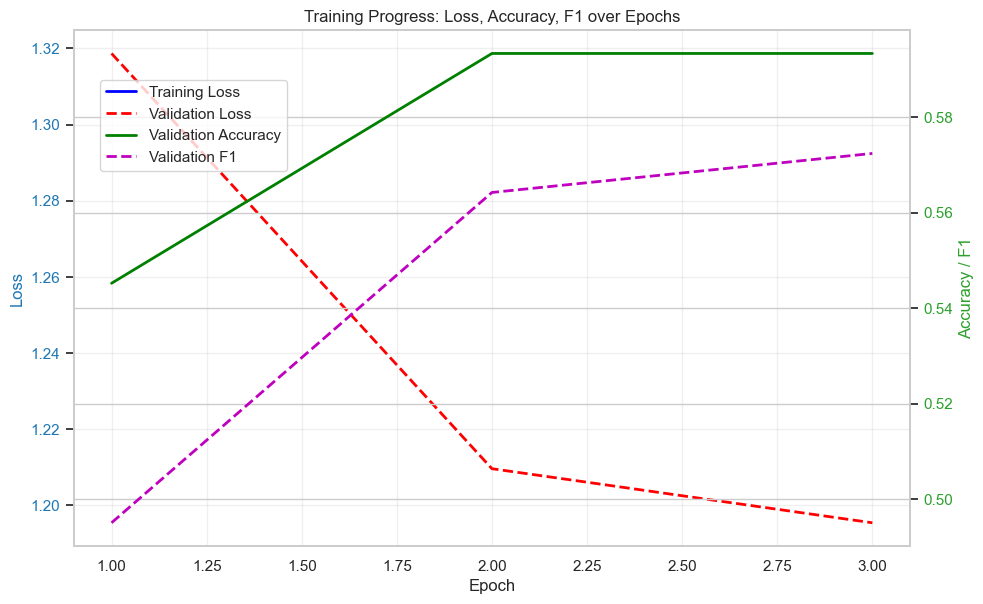

In [9]:
import json

LOG_PATH = "./phobert-emotion/checkpoint-1308/trainer_state.json"

if os.path.exists(LOG_PATH):
    with open(LOG_PATH, 'r') as f:
        trainer_state = json.load(f)

    logs = trainer_state['log_history']
    
    # D√πng dict ƒë·ªÉ gom theo epoch
    epoch_data = {}
    
    for log in logs:
        if 'epoch' not in log:
            continue
        epoch = log['epoch']
        if epoch not in epoch_data:
            epoch_data[epoch] = {}
        
        # L∆∞u training loss (n·∫øu c√≥)
        if 'loss' in log:
            epoch_data[epoch]['train_loss'] = log['loss']
        # L∆∞u validation metrics (n·∫øu c√≥)
        if 'eval_loss' in log:
            epoch_data[epoch]['val_loss'] = log['eval_loss']
            epoch_data[epoch]['val_acc'] = log['eval_accuracy']
            epoch_data[epoch]['val_f1'] = log['eval_f1']
    
    # S·∫Øp x·∫øp theo epoch
    sorted_epochs = sorted(epoch_data.keys())
    epochs = []
    train_loss = []
    val_loss = []
    val_acc = []
    val_f1 = []
    
    for ep in sorted_epochs:
        data = epoch_data[ep]
        # Ch·ªâ th√™m n·∫øu c√≥ ƒë·ªß c·∫£ train v√† val (ho·∫∑c √≠t nh·∫•t val)
        if 'val_loss' in data:
            epochs.append(ep)
            train_loss.append(data.get('train_loss', None))  # c√≥ th·ªÉ None
            val_loss.append(data['val_loss'])
            val_acc.append(data['val_acc'])
            val_f1.append(data['val_f1'])
    
    # Lo·∫°i b·ªè c√°c ƒëi·ªÉm train_loss l√† None (n·∫øu c·∫ßn)
    # Nh∆∞ng ƒë·ªÉ v·∫Ω, ta c·∫ßn x·ª≠ l√Ω None ‚Üí thay b·∫±ng gi√° tr·ªã g·∫ßn nh·∫•t ho·∫∑c b·ªè qua
    # ƒê∆°n gi·∫£n nh·∫•t: ch·ªâ v·∫Ω val_loss/val_acc/val_f1, v√† train_loss n·∫øu c√≥
    
    # V·∫Ω bi·ªÉu ƒë·ªì
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color1 = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color1)
    # V·∫Ω train loss ch·ªâ v·ªõi c√°c gi√° tr·ªã kh√¥ng None
    train_loss_clean = [x if x is not None else np.nan for x in train_loss]
    ax1.plot(epochs, train_loss_clean, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.set_ylabel('Accuracy / F1', color=color2)
    ax2.plot(epochs, val_acc, 'g-', label='Validation Accuracy', linewidth=2)
    ax2.plot(epochs, val_f1, 'm--', label='Validation F1', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout()
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.title('Training Progress: Loss, Accuracy, F1 over Epochs')
    plt.show()
else:
    print("‚ö†Ô∏è Kh√¥ng t√¨m th·∫•y file trainer_state.json ‚Äî kh√¥ng th·ªÉ v·∫Ω bi·ªÉu ƒë·ªì loss/accuracy.")

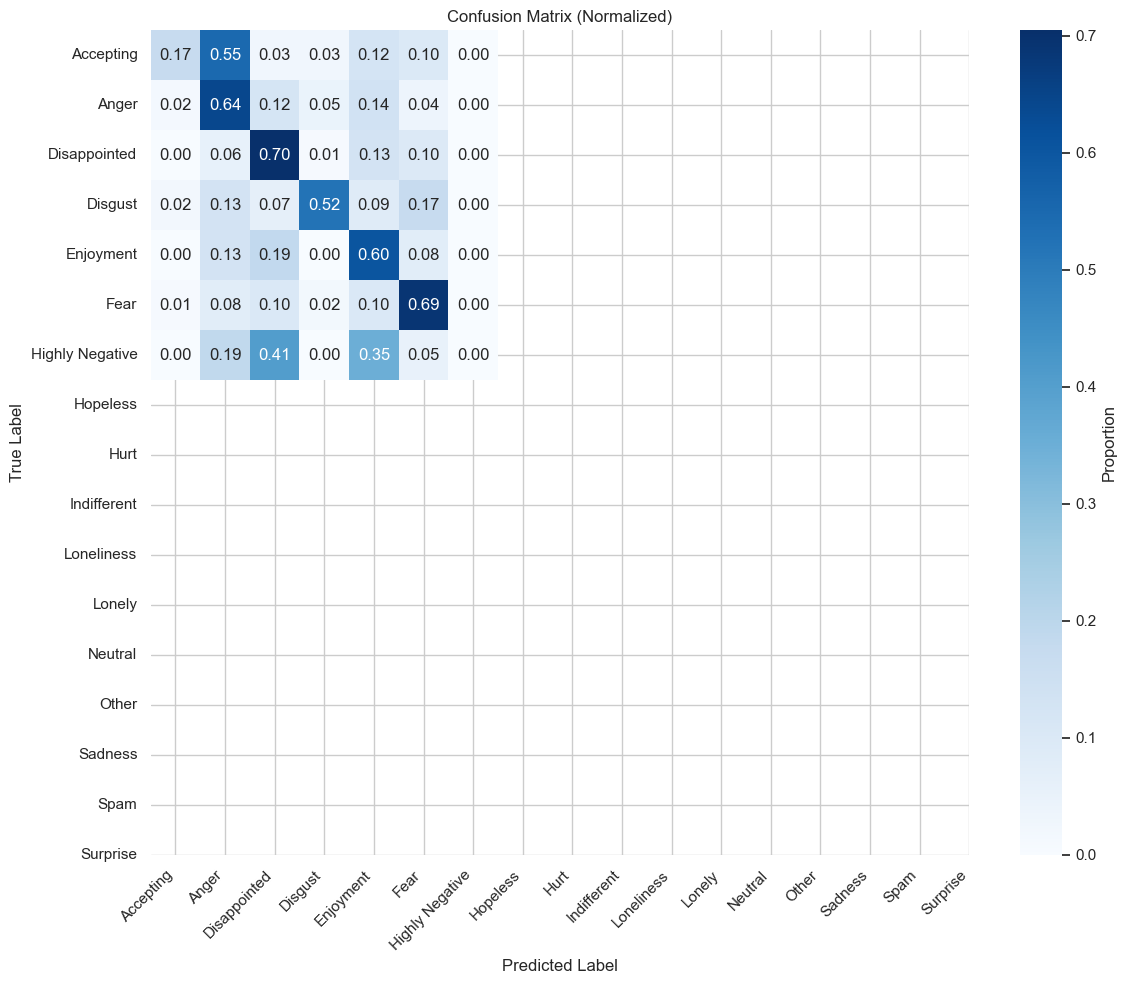

In [10]:
# T·∫°o confusion matrix
cm = confusion_matrix(labels, preds, normalize='true')

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()),
            cbar_kws={'label': 'Proportion'})
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# T·∫°o classification report
# L·∫•y c√°c l·ªõp th·ª±c s·ª± xu·∫•t hi·ªán trong t·∫≠p test
unique_label_ids = sorted(np.unique(np.concatenate([labels, preds])))
target_names = [id2label[i] for i in unique_label_ids]

# T·∫°o classification report
report = classification_report(
    labels, 
    preds, 
    labels=unique_label_ids,
    target_names=target_names, 
    digits=4
)

print("üìä Classification Report (per class):\n")
print(report)

üìä Classification Report (per class):

              precision    recall  f1-score   support

       Anger     0.6364    0.1750    0.2745        40
     Disgust     0.5414    0.6439    0.5882       132
   Enjoyment     0.6570    0.7047    0.6800       193
        Fear     0.6857    0.5217    0.5926        46
       Other     0.5032    0.6047    0.5493       129
     Sadness     0.6250    0.6897    0.6557       116
    Surprise     0.0000    0.0000    0.0000        37

    accuracy                         0.5916       693
   macro avg     0.5212    0.4771    0.4772       693
weighted avg     0.5666    0.5916    0.5686       693



In [13]:
# L·∫•y 5 c√¢u ng·∫´u nhi√™n t·ª´ test set
sample_indices = np.random.choice(len(test_df), 5, replace=False)

for idx in sample_indices:
    text = test_df.iloc[idx]["text"]
    true_label = test_df.iloc[idx]["label"]
    
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # D·ª± ƒëo√°n
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()
        pred_label = id2label[pred_idx]
        confidence = probs[0][pred_idx].item()

    print(f"üìå C√¢u: {text}")
    print(f"‚úÖ Nh√£n th·∫≠t: {true_label}")
    print(f"‚úÖ Nh√£n d·ª± ƒëo√°n: {pred_label} (ƒë·ªô tin c·∫≠y: {confidence:.4f})")
    print("-" * 80)

üìå C√¢u: m·∫•y th·∫±ng ·ªü ngo√†i b√¨nh lu·∫≠n g·∫∑p tao tao x√© m·ªè t·ª´ng ƒë·ª©a . cha m·∫π ƒë√©o d·∫°y ƒë·ªÉ x√£ h·ªôi d·∫°y nh√© . c√≤n ph√®n l·∫Øm
‚úÖ Nh√£n th·∫≠t: Anger
‚úÖ Nh√£n d·ª± ƒëo√°n: Disgust (ƒë·ªô tin c·∫≠y: 0.4442)
--------------------------------------------------------------------------------
üìå C√¢u: c·ª©u em n√≥ v·ªõi
‚úÖ Nh√£n th·∫≠t: Sadness
‚úÖ Nh√£n d·ª± ƒëo√°n: Other (ƒë·ªô tin c·∫≠y: 0.5904)
--------------------------------------------------------------------------------
üìå C√¢u: ƒë√¥i khi th√≠ch n√≥i chuy·ªán ch·ªâ v√¨ n√≥i chuy·ªán h·ª£p v√† v√¨ th√≠ch n√≥i chuy·ªán ch·ª© th·∫≠t ra ch·∫£ ph·∫£i y√™u ƒë∆∞∆°ng hay th√≠ch ki·ªÉu trai g√°i g√¨
‚úÖ Nh√£n th·∫≠t: Other
‚úÖ Nh√£n d·ª± ƒëo√°n: Other (ƒë·ªô tin c·∫≠y: 0.5118)
--------------------------------------------------------------------------------
üìå C√¢u: m·∫•t d·∫°y t·ª´ nh·ªè , ƒë·∫πp m·∫∑t khi b·ªë m·∫π n√≥ ƒëang ng·ªìi xem tivi , c·ª© t∆∞·ªüng hay
‚úÖ Nh√£n th·∫≠t: Disgust
‚úÖ Nh√£n d·ª± ƒëo√°

In [14]:
# T√¨m c√°c m·∫´u b·ªã d·ª± ƒëo√°n sai
wrong_preds = test_df.copy()
wrong_preds['predicted'] = [id2label[p] for p in preds]
wrong_preds['correct'] = wrong_preds['label'] == wrong_preds['predicted']

# L·ªçc ra c√°c m·∫´u sai
errors = wrong_preds[~wrong_preds['correct']].reset_index(drop=True)

print(f"‚ùå C√≥ {len(errors)} m·∫´u b·ªã d·ª± ƒëo√°n sai trong {len(test_df)} m·∫´u test.")

# Hi·ªÉn th·ªã 5 m·∫´u ƒë·∫ßu ti√™n
if len(errors) > 0:
    print("\nüìù M·ªôt v√†i v√≠ d·ª• v·ªÅ l·ªói:")
    for i in range(min(5, len(errors))):
        row = errors.iloc[i]
        print(f"Text: {row['text']}")
        print(f"True: {row['label']} | Predicted: {row['predicted']}")
        print("-" * 60)

‚ùå C√≥ 283 m·∫´u b·ªã d·ª± ƒëo√°n sai trong 693 m·∫´u test.

üìù M·ªôt v√†i v√≠ d·ª• v·ªÅ l·ªói:
Text: ng∆∞·ªùi ta c√≥ b·∫°n b√® nh√¨n vui th·∫≠t
True: Sadness | Predicted: Enjoyment
------------------------------------------------------------
Text: cho ngh·ªâ vi√™c m√≥i ƒë√∫ng sao goi l√† k·ª∑ lu·∫≠t
True: Surprise | Predicted: Disgust
------------------------------------------------------------
Text: kinh v√£i üò°
True: Disgust | Predicted: Fear
------------------------------------------------------------
Text: nh√† th√¨ kh√¥ng xa l·∫Øm nh∆∞ng ch∆∞a bao gi·ªù ƒëi v√¨ s·ª£ b·ªã ƒë√® b·∫πp lu√¥n ng∆∞·ªùi =)))))
True: Fear | Predicted: Enjoyment
------------------------------------------------------------
Text: b·ªë kh√¥ng th√≠ch n·ªôp ƒë·∫•y m√†y th√≠ch √Ω ki·∫øn kh√¥ng
True: Anger | Predicted: Other
------------------------------------------------------------


In [15]:
# L∆∞u classification report v√†o file
with open("./evaluation_report.txt", "w") as f:
    f.write("=== Evaluation Report ===\n")
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"F1-score: {f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

print("‚úÖ B√°o c√°o ƒë√°nh gi√° ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o ./evaluation_report.txt")

‚úÖ B√°o c√°o ƒë√°nh gi√° ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o ./evaluation_report.txt


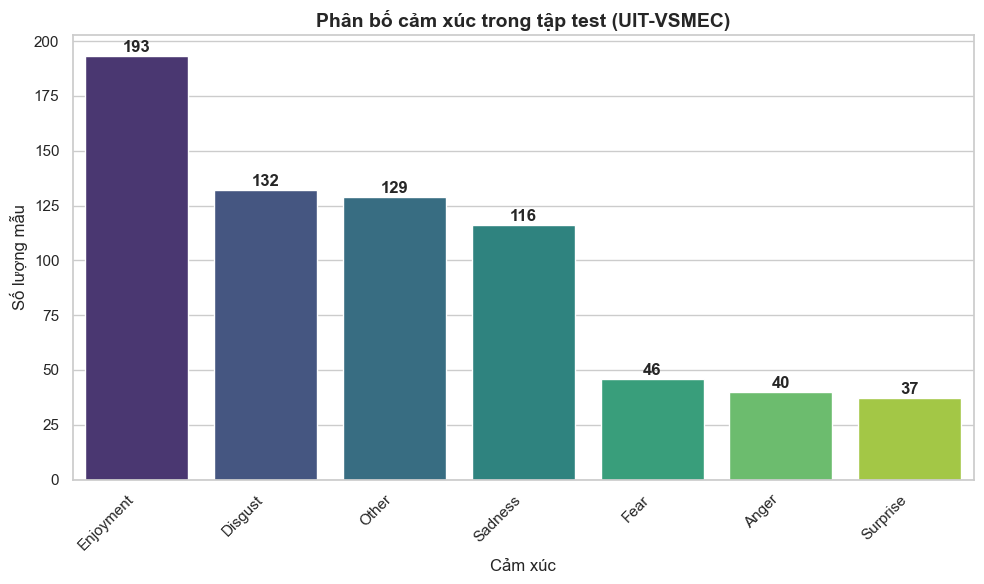

In [16]:
plt.figure(figsize=(10, 6))
label_counts = test_df['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Ph√¢n b·ªë c·∫£m x√∫c trong t·∫≠p test (UIT-VSMEC)", fontsize=14, weight='bold')
plt.xlabel("C·∫£m x√∫c", fontsize=12)
plt.ylabel("S·ªë l∆∞·ª£ng m·∫´u", fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

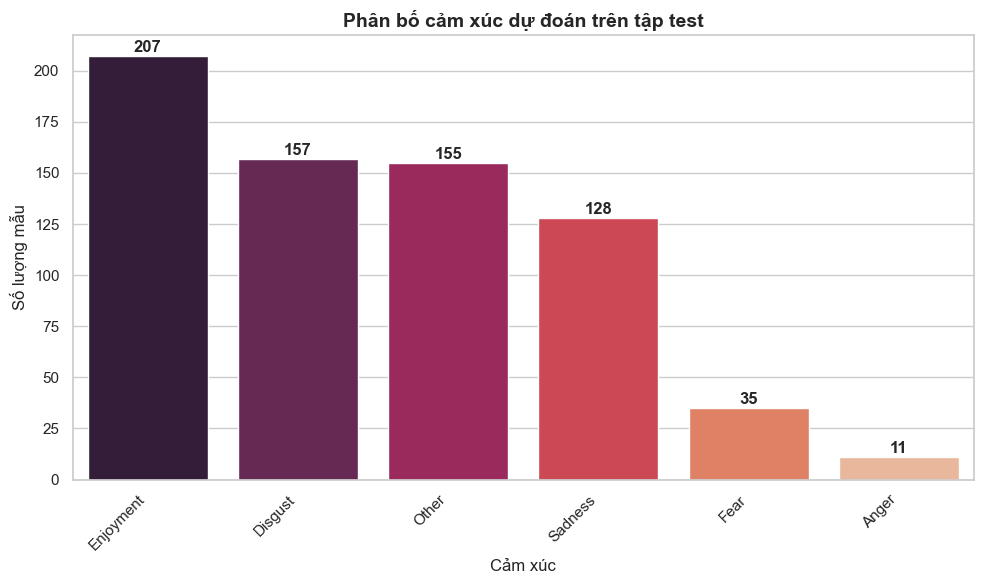

In [17]:
plt.figure(figsize=(10, 6))
pred_labels = [id2label[p] for p in preds]
pred_counts = pd.Series(pred_labels).value_counts()
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="rocket")
plt.title("Ph√¢n b·ªë c·∫£m x√∫c d·ª± ƒëo√°n tr√™n t·∫≠p test", fontsize=14, weight='bold')
plt.xlabel("C·∫£m x√∫c", fontsize=12)
plt.ylabel("S·ªë l∆∞·ª£ng m·∫´u", fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(pred_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

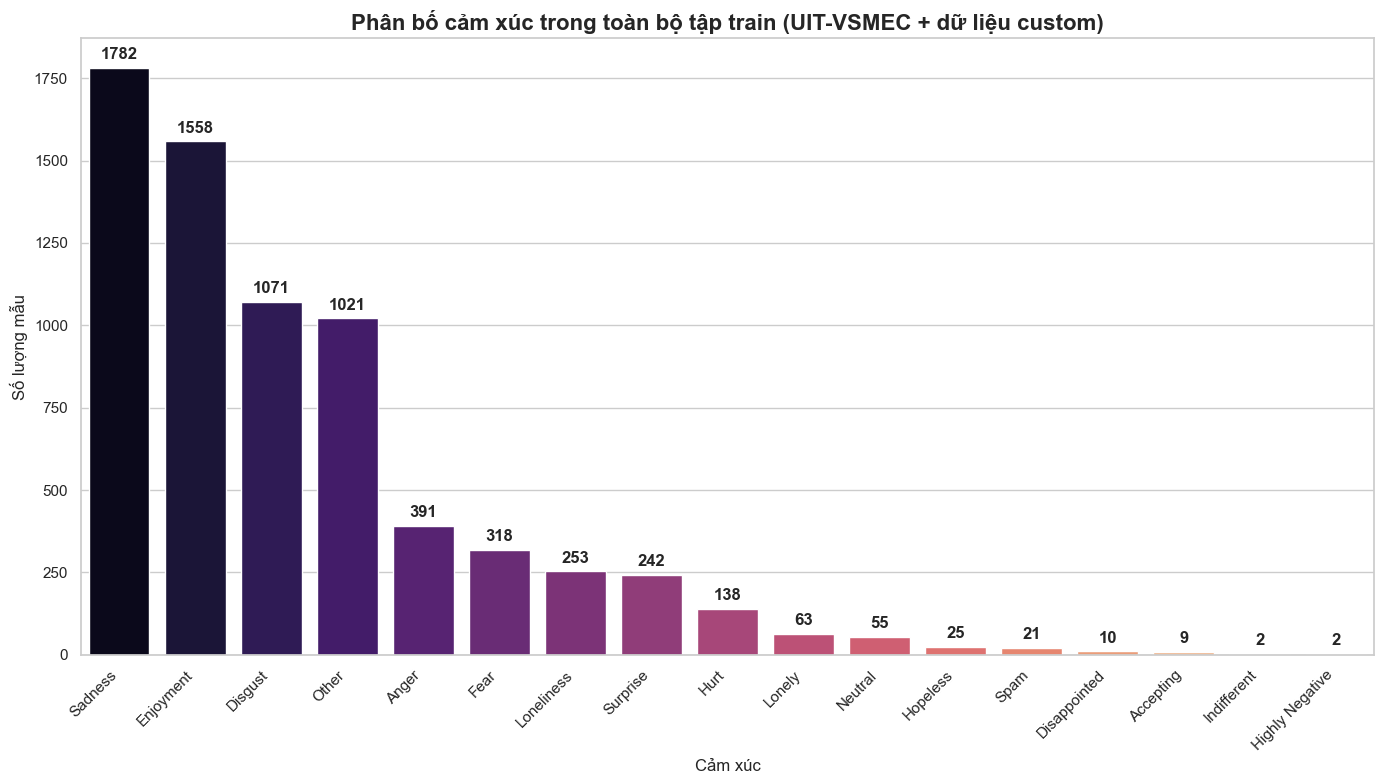

‚úÖ T·ªïng s·ªë m·∫´u train: 6961
‚úÖ S·ªë l·ªõp c·∫£m x√∫c: 17

Top 5 l·ªõp nhi·ªÅu nh·∫•t:
label
Sadness      1782
Enjoyment    1558
Disgust      1071
Other        1021
Anger         391
Name: count, dtype: int64

Top 5 l·ªõp √≠t nh·∫•t:
label
Spam               21
Disappointed       10
Accepting           9
Indifferent         2
Highly Negative     2
Name: count, dtype: int64


In [18]:
# ƒê∆∞·ªùng d·∫´n
UIT_PATH = "UIT-VSMEC"
DATA_PATH = "data"

# Load UIT-VSMEC train
train_uit = pd.read_csv(os.path.join(UIT_PATH, "train.csv"))
train_uit = train_uit.rename(columns={"Sentence": "text", "Emotion": "label"})
train_uit["label"] = train_uit["label"].str.strip().str.title()

# Load d·ªØ li·ªáu custom
data1 = pd.read_csv(os.path.join(DATA_PATH, "data.csv")).rename(columns={"Comment": "text", "Emotion": "label"})
data2 = pd.read_csv(os.path.join(DATA_PATH, "augmented_dataset.csv"))[["text", "emotion"]].rename(columns={"emotion": "label"})
data3 = pd.read_csv(os.path.join(DATA_PATH, "temp_augmented.csv"))[["text", "emotion"]].rename(columns={"emotion": "label"})

# Chu·∫©n h√≥a nh√£n
for df in [data1, data2, data3]:
    df["label"] = df["label"].str.strip().str.title()

# G·ªôp l·∫°i
custom_train = pd.concat([data1, data2, data3], ignore_index=True)
full_train = pd.concat([train_uit, custom_train], ignore_index=True)

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(14, 8))
label_counts = full_train['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, palette="magma")
plt.title("Ph√¢n b·ªë c·∫£m x√∫c trong to√†n b·ªô t·∫≠p train (UIT-VSMEC + d·ªØ li·ªáu custom)", fontsize=16, weight='bold')
plt.xlabel("C·∫£m x√∫c", fontsize=12)
plt.ylabel("S·ªë l∆∞·ª£ng m·∫´u", fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + max(label_counts.values)*0.01, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# In t·ªïng quan
print(f"‚úÖ T·ªïng s·ªë m·∫´u train: {len(full_train)}")
print(f"‚úÖ S·ªë l·ªõp c·∫£m x√∫c: {full_train['label'].nunique()}")
print("\nTop 5 l·ªõp nhi·ªÅu nh·∫•t:")
print(label_counts.head())
print("\nTop 5 l·ªõp √≠t nh·∫•t:")
print(label_counts.tail())